In [1]:
%matplotlib notebook
import numpy as np
import os
import sys
np.random.seed(1)
import torch
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
sys.path.append(r'C:\lior\studies\master\projects\calibration\regression calibration\regression_calibration')
os.chdir(r'C:\lior\studies\master\projects\calibration\regression calibration\regression_calibration')
from src.data.data_generator_endovis import EndoVisDataset
from models import BreastPathQModel
from uce import uceloss, enceloss
from src.features.calibration_plots import plot_uncert, plot_frequency, plot_uncert_multi
from utils import nll_criterion_gaussian, avg_len
from scaling import set_scaler, scale_bins

matplotlib.rcParams['font.size'] = 8

In [11]:
base_model = 'efficientnetb4'

In [12]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
device = torch.device("cuda:0")

In [13]:
batch_size = 16

data_dir_val = 'C:/lior/studies/master/projects/calibration/regression calibration/Tracking_Robotic_Testing/Tracking'
data_dir_test = 'C:/lior/studies/master/projects/calibration/regression calibration/Tracking_Robotic_Testing/Tracking'
data_set_valid = EndoVisDataset(data_dir=data_dir_val, mode='val', augment=False, scale=0.5)
data_set_test = EndoVisDataset(data_dir=data_dir_test, mode='test', augment=False, scale=0.5)

assert len(data_set_valid) > 0
assert len(data_set_test) > 0
print(len(data_set_valid))
print(len(data_set_test))

calib_loader = torch.utils.data.DataLoader(data_set_valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(data_set_test, batch_size=batch_size, shuffle=False)

mode 2
mode 1
679
357


In [14]:
from glob import glob
model = BreastPathQModel(base_model, out_channels=2).to(device)

# checkpoint_path = glob(f"C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\{base_model}_gaussian_endovis_best_new.pth.tar")[0]
checkpoint_path = glob(f"C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\{base_model}_gaussian_endovis_199_new.pth.tar")[0]

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)

Loading previous weights at epoch 199 from
C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\efficientnetb4_gaussian_endovis_199_new.pth.tar


In [48]:
model.eval()
y_p_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

        y_p_calib.append(y_p.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach())

100%|██████████| 43/43 [01:56<00:00,  2.70s/it]


In [49]:
y_p_calib = torch.cat(y_p_calib, dim=1).clamp(0, 1).permute(1,0,2)
mu_calib = y_p_calib.mean(dim=1)
var_calib = torch.cat(vars_calib, dim=0)
logvars_calib = torch.cat(logvars_calib, dim=1).permute(1,0,2)
logvar_calib = logvars_calib.mean(dim=1)
target_calib = torch.cat(targets_calib, dim=0)

In [51]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_endovis_mu_target_calib_new_freeze_lr_3e-05_nll.pickle', 'wb') as handle:
    pickle.dump({'mu_calib': mu_calib, 
                 'target_calib': target_calib}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_endovis_mu_target_calib_new_freeze_lr_3e-05_nll.pickle', 'rb') as handle:
    mu_dict = pickle.load(handle)
    mu_calib = mu_dict['mu_calib']
    target_calib = mu_dict['target_calib']

In [50]:
err_calib = (target_calib-mu_calib).pow(2).mean(dim=1, keepdim=True).sqrt()
errvar_calib = (y_p_calib-target_calib.unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

uncertainty = 'aleatoric'

uncert_calib_aleatoric = logvar_calib.exp().mean(dim=1, keepdim=True)
uncert_calib_epistemic = var_calib.mean(dim=1, keepdim=True)

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric.sqrt().clamp(0, 1)
    uncert_calib_laves = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic.sqrt().clamp(0, 1)
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total

In [12]:
print((err_calib**2).mean())
print(errvar_calib.mean())
print((uncert_calib**2).mean())
print(uncert_calib_aleatoric.sqrt().mean())
print(uncert_calib_epistemic.sqrt().mean())

#err_calib = errvar_calib.sqrt()

tensor(0.0002, device='cuda:0')
tensor(0.0003, device='cuda:0')
tensor(0.0002, device='cuda:0')
tensor(0.0125, device='cuda:0')
tensor(0.0089, device='cuda:0')


In [20]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu(), err_calib.cpu()[:,0], '.')

max_val = max(err_calib.max().item(), uncert_calib.max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.savefig(f'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/uncal_{base_model}_endovis')

<IPython.core.display.Javascript object>

: 

: 

In [51]:
# calculate optimal T
S = (err_calib**2 / uncert_calib**2).mean().sqrt()
print(S)

tensor(3.3860, device='cuda:0')


In [15]:
class Scaler(torch.nn.Module):
    def __init__(self, init_S=1.0):
        super().__init__()
        self.S = torch.nn.Parameter(torch.tensor([init_S]))

    def forward(self, x):
        return self.S.mul(x)

In [16]:
# find optimal S
scaler = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler.S], lr=3e-2, max_iter=200)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler.S.item())

1.1053190231323242


In [17]:
# calculate optimal S Laves
S = (err_calib**2 / uncert_calib_laves**2).mean().sqrt()
print(S)

# find optimal S Laves
scaler_laves = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler_laves.S], lr=3e-2, max_iter=200)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler_laves(uncert_calib_laves).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler_laves.S.item())

tensor(0.9007, device='cuda:0')
0.9006566405296326


In [40]:
class AuxModel(torch.nn.Module):
    def __init__(self, channels, hidden=16):
        super().__init__()
        self.linear1 = torch.nn.Linear(channels, hidden, bias=True)
        self.fc = torch.nn.Linear(hidden, channels, bias=True)

    def forward(self, x):
        x = 2*(x.log())
        y = self.linear1(x).relu()
        y = self.fc(y)
        
        if self.training:
            return y
        else:
            return (0.5*y).exp()

In [16]:
# find optimal aux
aux = AuxModel(1).to(device)
aux_opt = torch.optim.Adam(aux.parameters(), lr=3e-3, weight_decay=0)
lr_scheduler_net = optim.lr_scheduler.ReduceLROnPlateau(aux_opt, patience=100, factor=0.1)

aux.train()
for i in range(2000):
    aux_opt.zero_grad()
    loss = nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib)
    loss.backward()
    aux_opt.step()
    lr_scheduler_net.step(loss.item())

print(loss.item())

-4.622822284698486


In [17]:
aux.train()
print(nll_criterion_gaussian(mu_calib, uncert_calib.pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, (S*uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib).item())
aux.eval()

-4.41713285446167
-4.4205322265625
-4.429233551025391
-4.6228227615356445


AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [17]:
print(torch.nn.functional.mse_loss(uncert_calib**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_calib)**2, err_calib**2, reduction='sum').item())

0.00809614546597004
0.0060811033472418785
0.0060811033472418785
0.006124907173216343


<IPython.core.display.Javascript object>


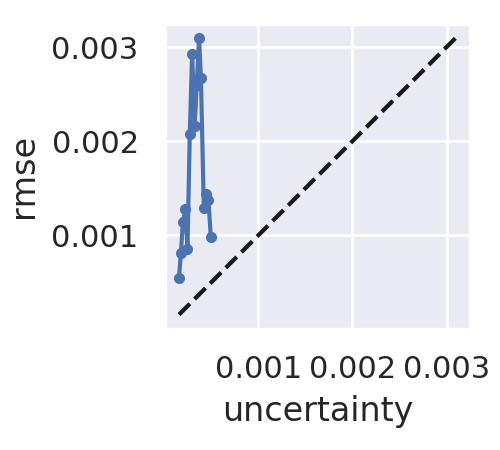

0.09151273407042027


In [18]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, uncert_calib**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>


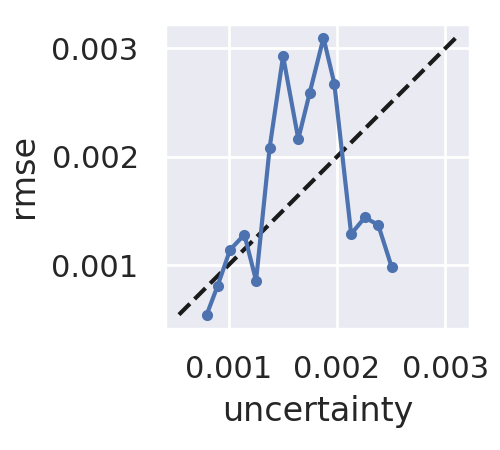

0.027724314713850617


In [19]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, (S*uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>


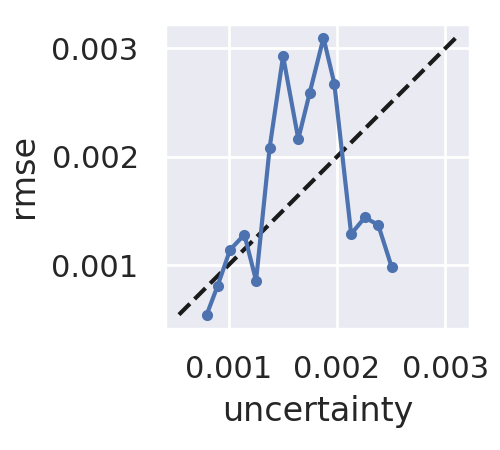

0.027724314713850617


<IPython.core.display.Javascript object>


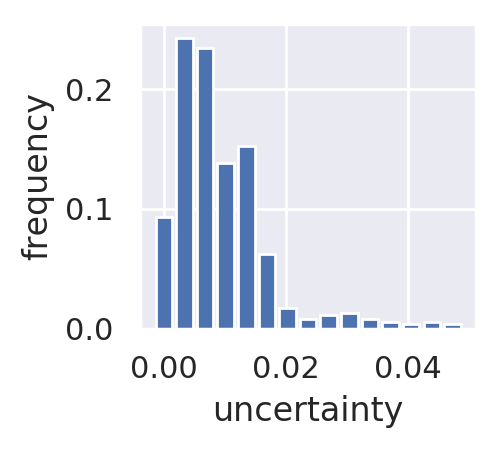

In [20]:
n_bins = 15
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, scaler(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)
fig, ax = plot_frequency(scaler(uncert_calib).cpu(), freq_in_bin.cpu(), n_bins=n_bins)
fig.show()

<IPython.core.display.Javascript object>


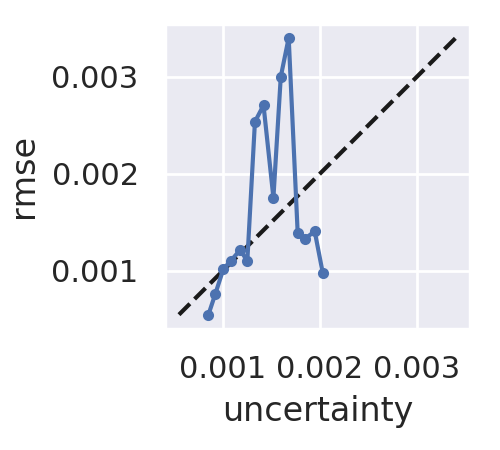

0.019011176482308656


In [21]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)

In [52]:
y_p_test_list = []
mu_test_list = []
var_test_list = []
logvars_test_list = []
logvar_test_list = []
target_test_list = []

for i in range(5):
    y_p_test = []
    mus_test = []
    vars_test = []
    logvars_test = []
    targets_test = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)

            y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

            y_p_test.append(y_p.detach())
            vars_test.append(var_bayesian.detach())
            logvars_test.append(logvar.detach())
            targets_test.append(target.detach())

        y_p_test = torch.cat(y_p_test, dim=1).clamp(0, 1).permute(1,0,2)
        mu_test = y_p_test.mean(dim=1)
        var_test = torch.cat(vars_test, dim=0)
        logvars_test = torch.cat(logvars_test, dim=1).permute(1,0,2)
        logvar_test = logvars_test.mean(dim=1)
        target_test = torch.cat(targets_test, dim=0)

        y_p_test_list.append(y_p_test)
        mu_test_list.append(mu_test)
        var_test_list.append(var_test)
        logvars_test_list.append(logvars_test)
        logvar_test_list.append(logvar_test)
        target_test_list.append(target_test)

100%|██████████| 23/23 [01:01<00:00,  2.68s/it]


In [54]:
err_test = [(target_test-mu_test).pow(2).mean(dim=1, keepdim=True).sqrt() for target_test, mu_test in zip(target_test_list, mu_test_list)]
errvar_test = [(y_p_test-target_test.unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1) for target_test, y_p_test in zip(target_test_list, y_p_test_list)]

uncertainty = 'aleatoric'

uncert_aleatoric_test = [logvar_test.exp().mean(dim=1, keepdim=True) for logvar_test in logvar_test_list]
uncert_epistemic_test = [var_test.mean(dim=1, keepdim=True) for var_test in var_test_list]

if uncertainty == 'aleatoric':
    uncert_test = [uncert_aleatoric_t.sqrt().clamp(0, 1) for uncert_aleatoric_t in uncert_aleatoric_test]
    uncert_test_laves = [(u_a_t + u_e_t).sqrt().clamp(0, 1) for u_a_t, u_e_t in zip(uncert_aleatoric_test, uncert_epistemic_test)]
elif uncertainty == 'epistemic':
    uncert_test = [uncert_epistemic_t.sqrt().clamp(0, 1) for uncert_epistemic_t in uncert_epistemic_test]
else:
    uncert_test = [(u_a_t + u_e_t).sqrt().clamp(0, 1) for u_a_t, u_e_t in zip(uncert_aleatoric_test, uncert_epistemic_test)]

In [55]:
import math

def calc_optimal_q(target_calib, mu_calib, uncert_calib, alpha=0.1, gc=False, single=True):

    if single:
        s_t = torch.abs(target_calib-mu_calib)[:, 0].unsqueeze(-1) / uncert_calib
    else:
        s_t = torch.abs(target_calib-mu_calib) / uncert_calib
    if gc:
        # q = 1.64485 * torch.sqrt((s_t**2).mean()).item()
        q = 1.64485 * s_t.median().item()
    else:
        s_t_sorted, _ = torch.sort(s_t, dim=0)
        # q_index = math.ceil((len(s_t_sorted) + 1) * (1 - alpha))
        q_index = math.ceil((len(s_t_sorted)) * (1 - alpha))
        q = s_t_sorted[q_index].item()
        # q = torch.quantile(s_t, (1 - alpha))
    
    return q

q = calc_optimal_q(target_calib, mu_calib, uncert_calib)

In [56]:
import pickle

# save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_endovis_new_conformal.pickle', 'wb') as handle:
# with open(save_path + f'{base_model}_gaussian_endovis_199_new_conformal.pickle', 'wb') as handle:
    pickle.dump({'mu': [mu_calib, mu_test_list],
                 'target': [target_calib, target_test_list],
                 'err': [err_calib, err_test], 
                 'uncert': [uncert_calib, uncert_test, uncert_calib_laves, uncert_test_laves],
                 's': S,
                 'q': q}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
# with open(save_path + f'{base_model}_gaussian_boneage_best_freeze_lr_3e-05_nll.pickle', 'rb') as handle:
# with open(save_path + f'{base_model}_gaussian_boneage_493_conformal.pickle', 'rb') as handle:
# with open(save_path + f'{base_model}_gaussian_endovis_199_new_conformal.pickle', 'rb') as handle:
with open(save_path + f'{base_model}_gaussian_endovis_new_conformal.pickle', 'rb') as handle:
    calib_dict = pickle.load(handle)
    err_calib = calib_dict['err'][0]
    err_test = calib_dict['err'][1]
    uncert_calib = calib_dict['uncert'][0]
    uncert_test = calib_dict['uncert'][1]
    uncert_calib_laves = calib_dict['uncert'][2]
    uncert_test_laves = calib_dict['uncert'][3]
    mu_calib = calib_dict['mu'][0]
    mu_test_list = calib_dict['mu'][1]
    target_calib = calib_dict['target'][0]
    target_test_list = calib_dict['target'][1]
    q = calib_dict['q']

In [16]:
calib = ((target_calib - mu_calib) / uncert_calib)
print(torch.mean(calib))
print(torch.std(calib))

tensor(0.6035, device='cuda:0')
tensor(3.3330, device='cuda:0')


In [17]:
from scipy import stats

calib = [calib_s.item() for calib_s in list(calib.mean(-1).squeeze())]

res = stats.normaltest(calib)
res2 = stats.kstest(calib, cdf=stats.norm.cdf)

print(res.pvalue)
print(res2.pvalue)

1.4025906885258432e-13
1.5034610368004916e-42


In [131]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
# with open(save_path + f'{base_model}_gaussian_endovis_new_best.pickle', 'rb') as handle:
with open(save_path + f'{base_model}_gaussian_endovis_new.pickle', 'rb') as handle:
    calib_dict = pickle.load(handle)
    err_calib = calib_dict['err'][0]
    err_test = calib_dict['err'][1]
    uncert_calib = calib_dict['uncert'][0]
    uncert_test = calib_dict['uncert'][1]
    uncert_calib_laves = calib_dict['uncert'][2]
    uncert_test_laves = calib_dict['uncert'][3]
    S = calib_dict['s']

In [132]:
print(S)

tensor(0.9040, device='cuda:0')


In [24]:
for i in range(len(err_test)):
    print((err_test[i]**2).mean())
    print(errvar_test[i].mean())
    print((uncert_test[i]**2).mean())
    print()

#err_test = [errvar.sqrt() for errvar in errvar_test]

tensor(0.0008, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(0.0002, device='cuda:0')

tensor(0.0008, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(0.0002, device='cuda:0')

tensor(0.0008, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(0.0002, device='cuda:0')

tensor(0.0008, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(0.0002, device='cuda:0')

tensor(0.0008, device='cuda:0')
tensor(0.0009, device='cuda:0')
tensor(0.0002, device='cuda:0')



In [22]:
aux.train()
for i in range(len(mu_test_list)):
    print(nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], (S*uncert_test[i]).pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], scaler(uncert_test[i]).pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], aux(uncert_test[i]), target_test_list[i]).item())
    print()
aux.eval()

-6.320302963256836
-6.467092990875244
-6.355734825134277
-6.158697605133057

-6.322774410247803
-6.4712724685668945
-6.358524322509766
-6.160892009735107

-6.32582950592041
-6.47330904006958
-6.361389636993408
-6.160848617553711

-6.317325592041016
-6.46246862411499
-6.352450370788574
-6.149840354919434

-6.324982643127441
-6.473216533660889
-6.360683441162109
-6.160848617553711



AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [26]:
for i in range(len(mu_test_list)):
    print(torch.nn.functional.mse_loss(uncert_test[i]**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss((S*uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(scaler(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(aux(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print()

0.0005989453056827188
0.0006182909710332751
0.0005760081112384796
0.0005862967809662223

0.0005546642350964248
0.0005728238029405475
0.000533244397956878
0.0005423201946541667

0.0005964753800071776
0.0006146616069599986
0.0005750292330048978
0.0005837981589138508

0.0005806722911074758
0.0005988205666653812
0.0005592621164396405
0.000567949959076941

0.0006051587406545877
0.0006239178474061191
0.0005829710280522704
0.000592735770624131



In [24]:
def histedges_equalN(x, n_bins=15):
    npt = len(x)
    return np.interp(np.linspace(0, npt, n_bins + 1),
                    np.arange(npt),
                    np.sort(x))

def set_scaler(err_calib, uncert_calib, cross_validate='uce',
                     init_temp=2.5, log=True, num_bins=15, outlier=0.0):
    """
    Tune single scaler for the model (using the validation set) with cross-validation on NLL
    """
    # Calculate ECE before temperature scaling
    nll_criterion = nn.CrossEntropyLoss().cuda()
    before_scaling_uce = uceloss(err_calib**2, uncert_calib**2, single=True)
    if log:
        print('Before scaling - UCE: %.3f' % (before_scaling_uce * 100))
        
    # calculate optimal S
    S = (err_calib**2 / uncert_calib**2).mean().sqrt()
        
    n_bins = num_bins
    eps = 1e-5
    nll_val = 10 ** 7
    buce_val = 10 ** 7
        
    # Calculate UCE after single scaling
    after_single_scaling_uce = uceloss(err_calib**2, (S * uncert_calib)**2, single=True)
    if log:
        print('Optimal scaler: %.3f' % S)
        print('After single scaling- UCE: %.3f' % (after_single_scaling_uce * 100))
    
    init_scaler = 1.0
    
    bins_T = init_scaler*torch.ones(n_bins).cuda()
    uce_list = []
    uce_list.append(after_single_scaling_uce)
                    
    ece_ada_list = []
    count_high_acc = 0
    is_acc = False
    n, bin_boundaries = np.histogram(uncert_calib.squeeze(-1).cpu().detach(), histedges_equalN(uncert_calib.squeeze(-1).cpu().detach(), n_bins=n_bins))
    print(bin_boundaries)


    if cross_validate == 'uce':
        T_opt_buce = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
        T_buce = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
        buce_temperature = T_buce
    else:
        T_opt_nll = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
        T_nll = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
        nll_temperature = T_nll
    
    bin = 0
    
    # bin_boundaries = torch.linspace(uncert_calib.min().item(), uncert_calib.max().item(), n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = uncert_calib.gt(bin_lower.item()) * uncert_calib.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        if prop_in_bin.item() > outlier:
            if cross_validate == 'uce':
                errors_in_bin = (err_calib[in_bin]**2).float().mean()  # err()
                avg_uncert_in_bin = (uncert_calib[in_bin]**2).mean()  # uncert()
                S_bin = (errors_in_bin / avg_uncert_in_bin).sqrt()
                bins_T[bin] = S_bin
                avg_uncert_in_bin = ((S_bin * uncert_calib[in_bin])**2).mean()  # uncert() after calib
                buce_val = torch.abs(avg_uncert_in_bin - errors_in_bin)
            else:
                S_bin = (err_calib[in_bin]**2 / uncert_calib[in_bin]**2).mean().sqrt()
                bins_T[bin] = S_bin
                errors_in_bin = (err_calib[in_bin]**2).float().mean()  # err()
                avg_uncert_in_bin = ((S_bin * uncert_calib[in_bin])**2).mean()  # uncert()
                buce_val = torch.abs(avg_uncert_in_bin - errors_in_bin)
                                    
            samples = uncert_calib[in_bin].shape[0]
            print('uce in bin ', bin+1, ' :', (prop_in_bin * buce_val).item(), ', number of samples: ', samples)

        bin += 1

    print(bins_T)
    uncert_calib_after = uncert_calib.clone()
    for inx, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
        in_bin = uncert_calib.gt(bin_lower.item()) * uncert_calib.le(bin_upper.item())
        uncert_calib_after[in_bin] = bins_T[inx] * uncert_calib[in_bin]
    current_uce = uceloss(err_calib**2, uncert_calib_after**2, single=True)
    print(f'After bins scaling by {cross_validate} - UCE:', current_uce.item() * 100)

    return bins_T, S, bin_boundaries, current_uce.item()

def scale_bins(err_test, uncert_test, bins_T, bin_boundaries, num_bins=15):
    uncert_test_after = uncert_test.clone()
    
    # bin_boundaries = torch.linspace(uncert_test.min().item(), uncert_test.max().item(), n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = uncert_test.gt(bin_lower.item()) * uncert_test.le(bin_upper.item())
        if any(in_bin):
            uncert_test_after[in_bin] = bins_T[bin] * uncert_test_after[in_bin]
            samples = uncert_test[in_bin].shape[0]
            print(f'Number of samples in bin {bin+1} test: ', samples)
        bin += 1
    uce = uceloss(err_test**2, uncert_test_after**2, single=True)
    
    return uce, uncert_test_after

def enceloss(errors, uncert, n_bins=15, outlier=0.0, range=None, single=None):
    device = errors.device
    if range == None:
        bin_boundaries = torch.linspace(uncert.min().item(), uncert.max().item(), n_bins + 1, device=device)
    else:
        bin_boundaries = torch.linspace(range[0], range[1], n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    errors_in_bin_list = []
    avg_uncert_in_bin_list = []
    ence_per_bin = []

    ence = torch.zeros(1, device=device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |RMV - RMSE| / RMV in each bin
        in_bin = uncert.gt(bin_lower.item()) * uncert.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean() 
        if prop_in_bin.item() > outlier:
            errors_in_bin = errors[in_bin].float().mean().sqrt()  # RMV()
            avg_uncert_in_bin = uncert[in_bin].mean().sqrt()  # RMSE()
            ence_in_bin = torch.abs(avg_uncert_in_bin - errors_in_bin) / errors_in_bin
            ence_per_bin.append(ence_in_bin)
            ence += ence_in_bin

            errors_in_bin_list.append(errors_in_bin)
            avg_uncert_in_bin_list.append(avg_uncert_in_bin)

    err_in_bin = torch.tensor(errors_in_bin_list, device=device)
    avg_uncert_in_bin = torch.tensor(avg_uncert_in_bin_list, device=device)

    if single:
        return ence.mean()
    else:
        return ence.mean(), err_in_bin, avg_uncert_in_bin, ence_per_bin


In [25]:
# bins_T, S, bin_boundaries, uce = set_scaler(err_calib, uncert_calib, num_bins=15)

uce_s_bins_list = []
err_s_bins_list = []
uncert_s_bins_list = []
ence_bins_list = []
for i in range(len(err_test)):
    for b in range(5, 25):
        n_bins = b
        bins_T, S, bin_boundaries, uce = set_scaler(err_calib, uncert_calib, num_bins=n_bins, cross_validate='uce')
        uce, uncert_test_after = scale_bins(err_test[i], uncert_test[i], bins_T, bin_boundaries, num_bins=n_bins)
        uce_s_bins, err_s_bins, uncert_s_bins, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test_after**2, n_bins=15)
        ence_bins = enceloss(err_test[i]**2, uncert_test_after**2, n_bins=15, single=True)
        
        print(f'{n_bins} bins with {uce_s_bins} UCE')
        print(f'{n_bins} bins with {ence_bins} ENCE')
    
        if n_bins == 5:
            best_uce = uce_s_bins
            ence = ence_bins
            best_err_s_bins = err_s_bins
            best_uncert_s_bins = uncert_s_bins
            mean_uce = best_uce
            best_n_bins = 5
            best_bins_T = bins_T
        else:
            mean_uce = uce_s_bins
            if mean_uce < best_uce:
                best_n_bins = n_bins
                best_uce = mean_uce
                ence = ence_bins
                best_err_s_bins = err_s_bins
                best_uncert_s_bins = uncert_s_bins
                best_bins_T = bins_T
    
    uce_s_bins_list.append(best_uce.cpu())
    err_s_bins_list.append(best_err_s_bins.cpu())
    uncert_s_bins_list.append(best_uncert_s_bins.cpu())
    ence_bins_list.append(ence.cpu())
    # uce_s_bins_list.append(uce_s_bins.cpu())
    # err_s_bins_list.append(err_s_bins.cpu())
    # uncert_s_bins_list.append(uncert_s_bins.cpu())

print(f'{best_n_bins} bins, UCE:', (torch.stack(uce_s_bins_list)*100).mean().item(), (torch.stack(uce_s_bins_list)*100).var().sqrt().item())
print(f'{best_n_bins} bins, ENCE:', (torch.stack(ence_bins_list)).mean().item())

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_endovis_s_bins_new_best.pickle', 'wb') as handle:
    pickle.dump({'s_bins': best_bins_T
                 ,'s': S}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)


Before scaling - UCE: 0.025
Optimal scaler: 0.847
After single scaling- UCE: 0.020
[0.01992666 0.02241792 0.02488461 0.02840842 0.03234366 0.0435348 ]
uce in bin  1  : 5.786475899133281e-12 , number of samples:  135
uce in bin  2  : 2.9146693739101615e-12 , number of samples:  136
uce in bin  3  : 1.1658677495640646e-11 , number of samples:  136
uce in bin  4  : 0.0 , number of samples:  136
uce in bin  5  : 0.0 , number of samples:  135
tensor([0.6708, 0.6051, 0.9971, 1.0171, 0.8761], device='cuda:0')
After bins scaling by uce - UCE: 0.008378502388950437
Number of samples in bin 1 test:  4
Number of samples in bin 2 test:  4
Number of samples in bin 3 test:  24
Number of samples in bin 4 test:  96
Number of samples in bin 5 test:  191
5 bins with tensor([0.0005], device='cuda:0') UCE
5 bins with 8.38293170928955 ENCE
Before scaling - UCE: 0.025
Optimal scaler: 0.847
After single scaling- UCE: 0.020
[0.01992666 0.02209437 0.02415303 0.02626647 0.02913772 0.03394549
 0.0435348 ]
uce in 

In [6]:
import math

def calc_optimal_q(target_calib, mu_calib, uncert_calib, err_calib=None, alpha=0.1, gc=False, single=False):

    if single:
        s_t = torch.abs(target_calib-mu_calib)[:, 0].unsqueeze(-1) / uncert_calib
    else:
        s_t = torch.abs(target_calib-mu_calib) / uncert_calib
    if gc:
        # q = 1.64485 * torch.sqrt((s_t**2).mean()).item()
        # q = 1.64485 * s_t.median().item()
        S = (err_calib**2 / uncert_calib**2).mean().sqrt()
        # print(S)
        # q = 1.64485 * torch.sqrt((s_t**2).mean()).item()
        if alpha == 0.1:
            q = 1.64485 * S.item()
        elif alpha == 0.05:
            q = 1.95996 * S.item()
        else:
            print("Choose another value of alpha!! (0.1 / 0.05)")
    else:
        s_t_sorted, _ = torch.sort(s_t, dim=0)
        # q_index = math.ceil((len(s_t_sorted) + 1) * (1 - alpha))
        q_index = math.ceil((len(s_t_sorted)) * (1 - alpha))
        q = s_t_sorted[q_index].item()
        # q = torch.quantile(s_t, (1 - alpha))
    
    return q


In [8]:
#Conformal prediction
def histedges_equalN(x, n_bins=15):
    npt = len(x)
    return np.interp(np.linspace(0, npt, n_bins + 1),
                    np.arange(npt),
                    np.sort(x))

def set_scaler_conformal(target_calib, mu_calib, uncert_calib, err_calib=None, init_temp=2.5, log=True, num_bins=15, outlier=0.0, by_uncert=True, gc=False):
    """
    Tune single scaler for the model (using the validation set) with cross-validation on NLL
    """
        
    if gc:
        printed_type = 'GC'
    else:
        printed_type = 'CP'
            
    # Calculate optimal q using GC
    q = calc_optimal_q(target_calib, mu_calib, uncert_calib, err_calib=err_calib, alpha=0.05, gc=gc)
    
    after_single_scaling_avg_len = avg_len(uncert_calib, q, single=True)
    print('Optimal scaler {} (val): {:.3f}'.format(printed_type, q))
    print('After single scaling- Avg Length {} (val): {}'.format(printed_type, after_single_scaling_avg_len))
    
    after_single_scaling_avg_cov = avg_cov(mu_calib, q * uncert_calib, target_calib)
    print('After single scaling- Avg Cov {} (val): {}'.format(printed_type, after_single_scaling_avg_cov))
    
    init_scaler = q
    
    n_bins = num_bins
    
    bins_q = init_scaler*torch.ones(n_bins)
    
    if by_uncert:
        n, bin_boundaries = np.histogram(uncert_calib.squeeze(-1).cpu().detach(), histedges_equalN(uncert_calib.squeeze(-1).cpu().detach(), n_bins=n_bins))
    else:  
        n, bin_boundaries = np.histogram(mu_calib.squeeze(-1).cpu().detach(), histedges_equalN(mu_calib.squeeze(-1).cpu().detach(), n_bins=n_bins))
    # print(bin_boundaries)
    
    # if by_uncert:
    #     bin_boundaries = torch.linspace(uncert_calib.min().item(), uncert_calib.max().item(), n_bins + 1, device=device)
    # else:
    #     bin_boundaries = torch.linspace(mu_calib.min().item(), mu_calib.max().item(), n_bins + 1, device=device)

    T_opt_buce = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
    T_buce = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
    buce_temperature = T_buce
    
    bin = 0
    
    # bin_boundaries = torch.linspace(uncert_calib.min().item(), uncert_calib.max().item(), n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        if by_uncert:
            in_bin = uncert_calib.gt(bin_lower.item()) * uncert_calib.le(bin_upper.item())
        else:
            in_bin = mu_calib.gt(bin_lower.item()) * mu_calib.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        if prop_in_bin.item() > outlier:
            # q_bin = calc_optimal_q(target_calib.mean(dim=1, keepdim=True)[in_bin], mu_calib.mean(dim=1, keepdim=True)[in_bin], uncert_calib[in_bin], alpha=0.1, gc=gc, mean=False)
            q_bin = calc_optimal_q(target_calib[in_bin], mu_calib[in_bin], uncert_calib[in_bin], err_calib=err_calib[in_bin], alpha=0.05, gc=gc)
            bins_q[bin] = q_bin
            b_avg_len_val = avg_len(uncert_calib[in_bin], q_bin, single=True)
                                    
            samples = uncert_calib[in_bin].shape[0]
            print(f'Avg Length {printed_type} (val) in bin ', bin+1, ' :', (b_avg_len_val).item(), ', number of samples: ', samples)
            
            # b_avg_cov_val = avg_cov(mu_calib.mean(dim=1, keepdim=True)[in_bin], q_bin * uncert_calib[in_bin], target_calib.mean(dim=1, keepdim=True)[in_bin], mean=False)
            b_avg_cov_val = avg_cov(mu_calib[in_bin], q_bin * uncert_calib[in_bin], target_calib[in_bin])
            print(f'Avg Cov {printed_type} (val) in bin ', bin+1, ' :', (b_avg_cov_val), ', number of samples: ', samples)

        bin += 1

    print(f'q values {printed_type}:', bins_q)
    uncert_calib_after = uncert_calib.clone()
    for inx, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
        if by_uncert:
            in_bin = uncert_calib.gt(bin_lower.item()) * uncert_calib.le(bin_upper.item())
        else:
            in_bin = mu_calib.gt(bin_lower.item()) * mu_calib.le(bin_upper.item())
        uncert_calib_after[in_bin] = bins_q[inx] * uncert_calib[in_bin]
    current_avg_len = (2 * uncert_calib_after).mean()
    print(f'After bins scaling {printed_type} (val) by - Avg Length:', current_avg_len.item())
    
    avg_cov_val = avg_cov(mu_calib, uncert_calib_after, target_calib)
    print(f'After bins scaling {printed_type} (val) by - Avg Cov:', avg_cov_val)
    
    return bins_q, q, bin_boundaries, current_avg_len.item()

def avg_cov(mu, uncert, target, mean=False):
    total_cov = 0.0
    if mean:
        mu_mean = mu.mean(dim=1, keepdim=True)
        target_mean = target.mean(dim=1, keepdim=True)
    else:
        mu_mean = mu
        target_mean = target
    
    for mu_single, uncert_single, target_single in zip(mu, uncert, target):
        if mu_single - uncert_single <= target_single <= mu_single + uncert_single:
            total_cov += 1.0
            
    return total_cov / len(mu_mean)

def scale_bins_conformal(mu_test, uncert_test, bins_q, bin_boundaries, num_bins=15, by_uncert=True):
    
    uncert_test_after = uncert_test.clone()
    
    # bin_boundaries = torch.linspace(uncert_test.min().item(), uncert_test.max().item(), n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        if by_uncert:
            in_bin  = uncert_test.gt(bin_lower.item()) * uncert_test.le(bin_upper.item())
        else:
            in_bin  = mu_test.gt(bin_lower.item()) * mu_test.le(bin_upper.item())
        if any(in_bin):
            uncert_test_after[in_bin] = bins_q[bin] * uncert_test[in_bin]
        bin += 1
    avg_len_bins = (2 * uncert_test_after).mean()
    
    return avg_len_bins, uncert_test_after

def scale_bins_single_conformal(uncert_test, q):
    
    # Calculate Avg Length before temperature scaling
    before_scaling_avg_len = (2 * uncert_test).mean()
    print('Before scaling - Avg Length: %.3f' % (before_scaling_avg_len))
        
    # Calculate Avg Length after single scaling
    after_single_scaling_avg_len = avg_len(uncert_test, q, single=True)
    print('Optimal scaler: %.3f' % q)
    print(f'After single scaling- Avg Length: {after_single_scaling_avg_len}')
    
    return after_single_scaling_avg_len, before_scaling_avg_len

In [19]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
# with open(save_path + f'{base_model}_gaussian_boneage_best_freeze_lr_3e-05_nll.pickle', 'rb') as handle:
# with open(save_path + f'{base_model}_gaussian_boneage_493_conformal.pickle', 'rb') as handle:
# with open(save_path + f'{base_model}_gaussian_endovis_199_new_conformal.pickle', 'rb') as handle:
with open(save_path + f'{base_model}_gaussian_endovis_new_conformal.pickle', 'rb') as handle:
    calib_dict = pickle.load(handle)
    err_calib = calib_dict['err'][0]
    err_test = calib_dict['err'][1]
    uncert_calib = calib_dict['uncert'][0]
    uncert_test = calib_dict['uncert'][1]
    uncert_calib_laves = calib_dict['uncert'][2]
    uncert_test_laves = calib_dict['uncert'][3]
    mu_calib = calib_dict['mu'][0]
    mu_test_list = calib_dict['mu'][1]
    target_calib = calib_dict['target'][0]
    target_test_list = calib_dict['target'][1]
    q = calib_dict['q']

# Bins conformal prediction
avg_len_before_list = []
avg_len_single_list = []
avg_len_q_bins_list = []

avg_cov_before_list = []
avg_cov_after_single_list = []
avg_cov_after_bins_list = []

target_calib = target_calib.mean(dim=1, keepdim=True)
mu_calib = mu_calib.mean(dim=1, keepdim=True)
mu_test_list = [mu_test.mean(dim=1, keepdim=True) for mu_test in mu_test_list]
target_test_list = [target_test.mean(dim=1, keepdim=True) for target_test in target_test_list]
# target_calib = target_calib[:, 1].unsqueeze(-1)
# mu_calib = mu_calib[:, 1].unsqueeze(-1)
# mu_test_list = [mu_test[:, 1].unsqueeze(-1) for mu_test in mu_test_list]
# target_test_list = [target_test[:, 1].unsqueeze(-1) for target_test in target_test_list]

for i in range(len(err_test)):
    for b in range(2, 10):
        n_bins = b
        bins_q, q, bin_boundaries, avg_len_bins_val = set_scaler_conformal(target_calib, mu_calib, uncert_calib, num_bins=n_bins, by_uncert=True, gc=True, err_calib=err_calib)
        avg_len_bins, uncert_test_after = scale_bins_conformal(mu_test_list[i], uncert_test[i], bins_q, bin_boundaries, num_bins=n_bins, by_uncert=True)
        
        avg_cov_after_bins = avg_cov(mu_test_list[i], uncert_test_after, target_test_list[i])
        
        print(f'Test {n_bins} bins with Avg Length {avg_len_bins}')
        print(f'Test {n_bins} bins after bins with Cov Length {avg_cov_after_bins}')
        
        # bins_q_gc, q_gc, _, avg_len_bins_val_gc = set_scaler_conformal(target_calib, mu_calib, uncert_calib, num_bins=n_bins, by_uncert=False, gc=True)
    
        if n_bins == 2:
            best_avg_len = avg_len_bins
            mean_avg_len = best_avg_len
            best_n_bins = 2
            best_bins_q = bins_q
            best_avg_cov = avg_cov_after_bins
        else:
            mean_avg_len = avg_len_bins
            if mean_avg_len < best_avg_len:
                best_n_bins = n_bins
                best_avg_len = mean_avg_len
                best_bins_q = bins_q
                best_avg_cov = avg_cov_after_bins
                
    avg_len_single, avg_len_before = scale_bins_single_conformal(uncert_test[i], q)
    
    avg_cov_before = avg_cov(mu_test_list[i], uncert_test[i], target_test_list[i])
    avg_cov_after_single = avg_cov(mu_test_list[i], q * uncert_test[i], target_test_list[i])
    
    avg_len_before_list.append(avg_len_before.cpu())
    avg_len_single_list.append(avg_len_single.cpu())
    avg_len_q_bins_list.append(best_avg_len.cpu())
    
    avg_cov_before_list.append(avg_cov_before)
    avg_cov_after_single_list.append(avg_cov_after_single)
    avg_cov_after_bins_list.append(best_avg_cov)
    
print(f'Test before, Avg Length:', torch.stack(avg_len_before_list).mean().item())
print(f'Test after single, Avg Length:', torch.stack(avg_len_single_list).mean().item())
print(f'{best_n_bins} bins, Avg Length:', torch.stack(avg_len_q_bins_list).mean().item())

print(f'Test before with Avg Cov:', torch.tensor(avg_cov_before_list).mean().item())
print(f'Test after single with Avg Cov:', torch.tensor(avg_cov_after_single_list).mean().item())
print(f'{best_n_bins} bins, Avg Cov:', torch.tensor(avg_cov_after_bins_list).mean().item())
      
save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_endovis_q_bins_conformal_by_mu_10_bins.pickle', 'wb') as handle:
    pickle.dump({'q_bins': bins_q
                 ,'q': q}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)

Optimal scaler GC (val): 6.636
After single scaling- Avg Length GC (val): 0.11753623932600021
After single scaling- Avg Cov GC (val): 0.9823269513991163
Avg Length GC (val) in bin  1  : 0.07136310636997223 , number of samples:  339
Avg Cov GC (val) in bin  1  : 1.0 , number of samples:  339
Avg Length GC (val) in bin  2  : 0.16293105483055115 , number of samples:  339
Avg Cov GC (val) in bin  2  : 0.9970501474926253 , number of samples:  339
q values GC: tensor([4.5868, 8.1954])
After bins scaling GC (val) by - Avg Length: 0.11699172109365463
After bins scaling GC (val) by - Avg Cov: 0.9985272459499264
Test 2 bins with Avg Length 0.13471102714538574
Test 2 bins after bins with Cov Length 0.865546218487395
Optimal scaler GC (val): 6.636
After single scaling- Avg Length GC (val): 0.11753623932600021
After single scaling- Avg Cov GC (val): 0.9823269513991163
Avg Length GC (val) in bin  1  : 0.059634048491716385 , number of samples:  226
Avg Cov GC (val) in bin  1  : 1.0 , number of sample

In [65]:
if base_model == 'resnet101':
    uce_range = [0, 0.00025]
elif base_model == 'densenet201':
    uce_range = [0, 0.0005]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.0008]

n_bins = 15
uce_uncal_list = []
err_uncal_list = []
uncert_uncal_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((uncert_test[i]**2).max().item())
    # uce_uncal, err_uncal, uncert_uncal, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins, range=uce_range)
    uce_uncal, err_uncal, uncert_uncal, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, uncert_test[i]**2, n_bins=15, single=True)
    uce_uncal_list.append(uce_uncal.cpu())
    err_uncal_list.append(err_uncal.cpu())
    uncert_uncal_list.append(uncert_uncal.cpu())
    ence_bins_list.append(ence_bins.cpu())

print((torch.stack(uce_uncal_list)*100).mean().item(), (torch.stack(uce_uncal_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_uncal_list, uncert_uncal_list)

0.0009809262119233608
0.0009839815320447087
0.001031788531690836
0.0009687853162176907
0.000951828493271023
0.04367686063051224 0.0010449661640450358
4.487668037414551


In [66]:
if base_model == 'resnet101':
    uce_range = [0, 0.003]
elif base_model == 'densenet201':
    uce_range = [0, 0.0045]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.003]

n_bins = 15
uce_s_list = []
err_s_list = []
uncert_s_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((scaler_laves(uncert_test_laves[i])**2).max().item())
    # uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=n_bins, range=uce_range)
    uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=15, single=True)
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())
    ence_bins_list.append(ence_bins.cpu())
    

print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_s_list, uncert_s_list)

#fig, ax = plot_frequency(scaler_laves(uncert_test_laves[0]).cpu(), in_bin.cpu(), n_bins=n_bins)
#fig.show()

0.002412466099485755
0.002506427699699998
0.002666186774149537
0.0028049787506461143
0.002372179878875613
0.028372401371598244 0.002392886206507683
6.719118595123291


In [68]:
#Ethan
n_bins = 15
uce_s_list = []
err_s_list = []
uncert_s_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print(((S*uncert_test[i])**2).max().item())
    print(S)
    uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, (S*uncert_test[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, (S*uncert_test[i])**2, n_bins=15, single=True)
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())
    ence_bins_list.append(ence_bins.cpu())

print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())

0.0013140456285327673
tensor(1.1574, device='cuda:0')
0.0013181384420022368
tensor(1.1574, device='cuda:0')
0.0013821806060150266
tensor(1.1574, device='cuda:0')
0.0012977817095816135
tensor(1.1574, device='cuda:0')
0.0012750665191560984
tensor(1.1574, device='cuda:0')
0.035435646772384644 0.0022771575022488832
4.704928398132324


In [31]:
if base_model == 'resnet101':
    uce_range = [0, 0.003]
elif base_model == 'densenet201':
    uce_range = [0, 0.0045]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.003]

n_bins = 15
uce_aux_list = []
err_aux_list = []
uncert_aux_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((aux(uncert_test[i])**2).max().item())
    uce_aux, _, _, _, uce_per_bin = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=15, single=True)
    # _, err_aux, uncert_aux, _, uce_per_bin = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins, range=uce_range)
    uce_aux_list.append(uce_aux.cpu())
    ence_bins_list.append(ence_bins.cpu())
    # err_aux_list.append(err_aux.cpu())
    # uncert_aux_list.append(uncert_aux.cpu())

print((torch.stack(uce_aux_list)*100).mean().item(), (torch.stack(uce_aux_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_aux_list, uncert_aux_list)

0.08002376556396484
0.08063354343175888
0.08604127168655396
0.08434337377548218
0.08650510758161545
0.9994062185287476 0.010339424014091492
7.192543983459473


In [74]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [75]:
def save_log(base_model):
    with open(f"results_levi_endovis_{base_model}.log", "w") as f:
        print("MSE", file=f)
        print([(e**2).mean().item() for e in err_test], file=f)
        print("mean", np.mean([(e**2).mean().item() for e in err_test]), file=f)
        print("std ", np.std([(e**2).mean().item() for e in err_test]), file=f)
        print("", file=f)
        
        print("uncal", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_uncal_list], file=f)
        print("mean", (torch.stack(uce_uncal_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_uncal_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("aux", file=f)
        print("NLL", file=f)
        aux.train()
        nll = [nll_criterion_gaussian(mu_test_list[i], aux(uncert_test[i]), target_test_list[i]).item() for i in range(len(mu_test_list))]
        aux.eval()
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_aux_list], file=f)
        print("mean", (torch.stack(uce_aux_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_aux_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("s", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], scaler(uncert_test[i]).pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_s_list], file=f)
        print("mean", (torch.stack(uce_s_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_s_list)*100).var().sqrt().item(), file=f)
        print("S =", scaler.S.item(), file=f)
        print("", file=f)

In [76]:
if base_model == 'resnet101':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.2], [0, 0.2], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.0002, 0.0022])
    ax[0].set_ylim([-0.0002, 0.0022])
    ax[0].set_xticks([0, 0.002])
    ax[0].set_yticks([0, 0.002])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.2], [0, 0.2], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([0.0, 0.0032])
    ax[1].set_ylim([0.0, 0.0032])
    ax[1].set_xticks([0.001, 0.003])
    ax[1].set_yticks([0.001, 0.003])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.6, 0.825, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.2], [0, 0.2], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([0.0, 0.0032])
    ax[2].set_ylim([0.0, 0.0032])
    ax[2].set_xticks([0.001, 0.003])
    ax[2].set_yticks([0.001, 0.003])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.6, 0.825, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'EndoVis/ResNet-101', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_endovis_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [77]:
if base_model == 'densenet201':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.004], [0, 0.004], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.0002, 0.0042])
    ax[0].set_ylim([-0.0002, 0.0042])
    ax[0].set_xticks([0, 0.004])
    ax[0].set_yticks([0, 0.004])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.005], [0, 0.005], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([-0.0003, 0.0053])
    ax[1].set_ylim([-0.0003, 0.0053])
    ax[1].set_xticks([0, 0.005])
    ax[1].set_yticks([0, 0.005])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.6, 0.825, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.005], [0, 0.005], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([-0.0003, 0.0053])
    ax[2].set_ylim([-0.0003, 0.0053])
    ax[2].set_xticks([0, 0.005])
    ax[2].set_yticks([0, 0.005])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.6, 0.825, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'EndoVis/DenseNet-201', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_endovis_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

<IPython.core.display.Javascript object>


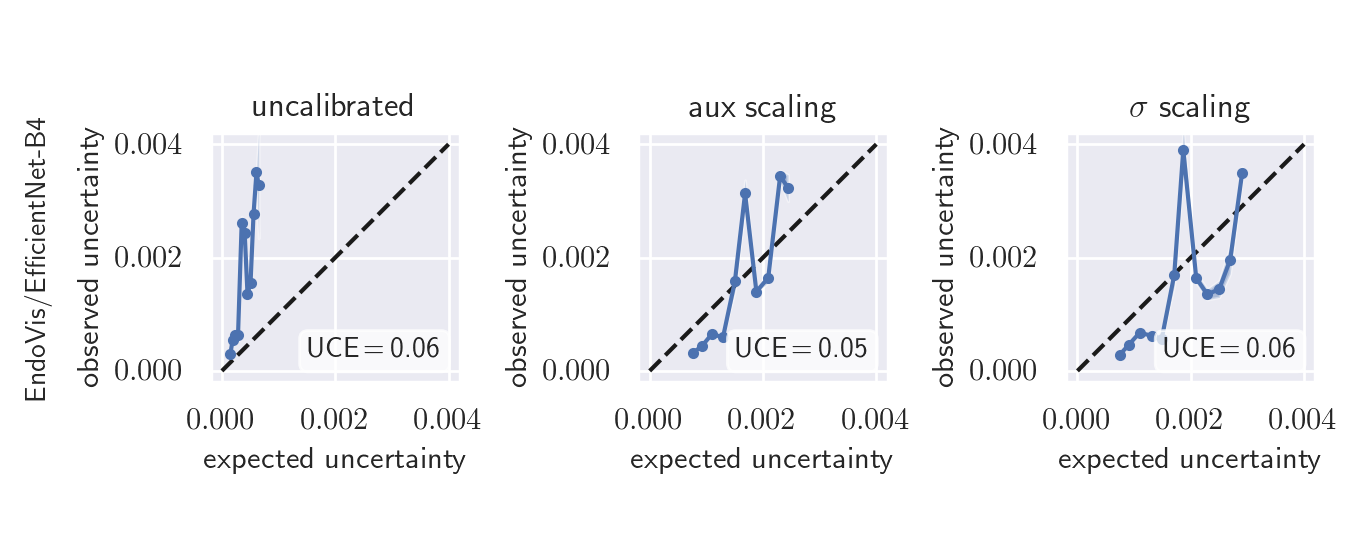

In [78]:
if base_model == 'efficientnetb4':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).std(dim=0).cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.004], [0, 0.004], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.0002, 0.0042])
    ax[0].set_ylim([-0.0002, 0.0042])
    ax[0].set_xticks([0, 0.002, 0.004])
    ax[0].set_yticks([0, 0.002, 0.004])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).std(dim=0).cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.004], [0, 0.004], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([-0.0002, 0.0042])
    ax[1].set_ylim([-0.0002, 0.0042])
    ax[1].set_xticks([0, 0.002, 0.004])
    ax[1].set_yticks([0, 0.002, 0.004])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).std(dim=0).cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.004], [0, 0.004], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([-0.0002, 0.0042])
    ax[2].set_ylim([-0.0002, 0.0042])
    ax[2].set_xticks([0, 0.002, 0.004])
    ax[2].set_yticks([0, 0.002, 0.004])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'EndoVis/EfficientNet-B4', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_endovis_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [79]:
np.save(f"uce_uncal_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uce_uncal_list]))
np.save(f"err_uncal_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in err_uncal_list]))
np.save(f"uncert_uncal_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uncert_uncal_list]))

np.save(f"uce_s_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uce_s_list]))
np.save(f"err_s_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in err_s_list]))
np.save(f"uncert_s_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uncert_s_list]))

np.save(f"uce_aux_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uce_aux_list]))
np.save(f"err_aux_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in err_aux_list]))
np.save(f"uncert_aux_levi_endovis_{base_model}", np.array([i.detach().numpy() for i in uncert_aux_list]))